# Local rearrangement visualization

Explore how `pento.rearrangement` searches for alternative placements of pentomino pieces.


## What `find_local_rearrangements` does

The helper searches every subset of pentomino pieces whose size falls between the requested `min_subset_size` and `max_subset_size`. For each subset it:

1. Collects every valid placement of the subset that stays within the cells originally occupied by the subset.
2. Performs a backtracking search to look for a conflict-free combination of those placements.
3. Returns the first combination that changes at least one piece position while keeping the rest of the board intact.

`trace_local_rearrangements` exposes the same search results but also records each placement that was tried, skipped because of overlaps, accepted, or backtracked.


In [ ]:
import sys

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

try:
    import pandas as pd
except ImportError:  # pragma: no cover - optional dependency in notebooks
    pd = None

from pathlib import Path

CUR = Path.cwd()
ROOT = CUR
while ROOT != ROOT.parent and not (ROOT / "pyproject.toml").exists():
    ROOT = ROOT.parent

SRC = ROOT / "src"

print("Detected ROOT:", ROOT)
print("Detected SRC :", SRC)

for p in (str(ROOT), str(SRC)):
    if p not in sys.path:
        sys.path.insert(0, p)


from pento.rearrangement import find_local_rearrangements, trace_local_rearrangements
from pento.visualization import plot_colored_label_grid

def sample_solution():
    """Return the canonical 6×10 solution used in the unit tests."""
    from tests.test_rearrangement import _sample_solution

    return _sample_solution()

solution_grid = sample_solution()
print("Loaded solution grid with shape", solution_grid.shape)


Detected ROOT: /workspaces/pento
Detected SRC : /workspaces/pento/src
Loaded solution grid with shape (6, 10)


In [2]:
rows = [
        "LUUUNWWTTT",
        "LUXUNNWWTI",
        "LXXXVNZWTI",
        "LLXFVNZZZI",
        "PPFFVVVYZI",
        "PPPFFYYYYI",
    ]
solution_grid = np.array([[cell for cell in row] for row in rows], dtype="<U1")

## Visualize the starting solution

The plot below colours each pentomino so the layout is easier to parse at a glance.


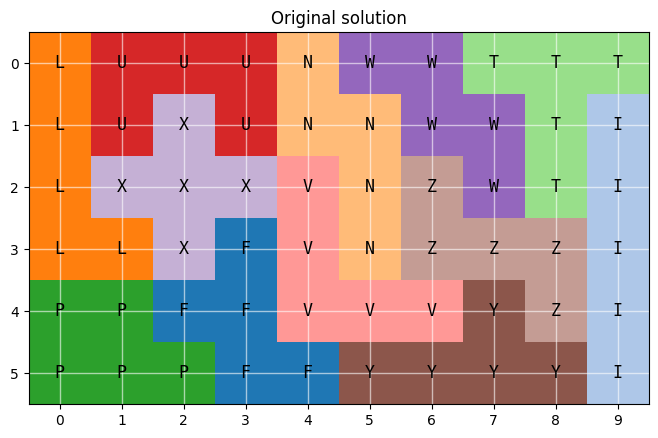

In [3]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_colored_label_grid(solution_grid, ax=ax, title="Original solution")
plt.show()


## Run the rearrangement search

Adjust the search bounds below to explore different subsets. Limiting `max_results` keeps the output compact while prototyping.


In [5]:
min_subset = 2
max_subset = 6  # Set to an integer to cap the subset size.
max_results = None

rearrangements = find_local_rearrangements(
    solution_grid,
    min_subset_size=min_subset,
    max_subset_size=max_subset,
    max_results=max_results,
)

print(f"Found {len(rearrangements)} rearrangement(s).")
for index, alt in enumerate(rearrangements, start=1):
    print(f"#{index}: pieces {alt.pieces}")


Found 4 rearrangement(s).
#1: pieces ('L', 'U')
#2: pieces ('N', 'W', 'Z')
#3: pieces ('I', 'L', 'P', 'T')
#4: pieces ('I', 'L', 'P', 'T', 'W', 'Z')


## Inspect one rearrangement in detail

Update `selection_index` to focus on a different result. The helper below plots the original subset alongside its alternative placement and summarises the search trace.


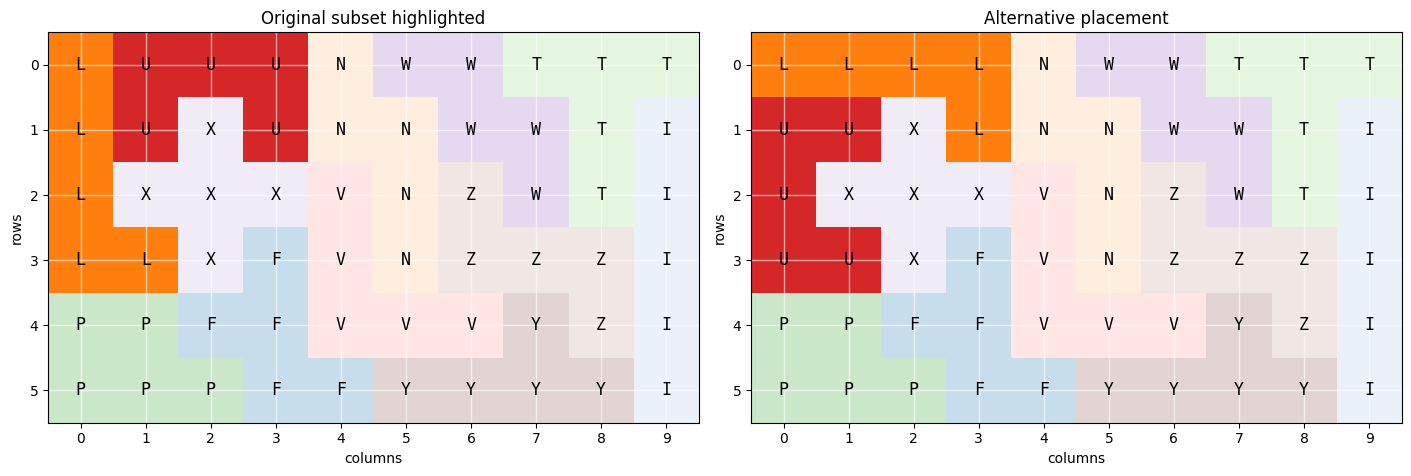

In [6]:
selection_index = 0  # zero-based index into `rearrangements`

if not rearrangements:
    raise ValueError("No rearrangements available. Re-run the search with different limits.")

selection = rearrangements[selection_index]
subset = selection.pieces

#traced = trace_local_rearrangements(
#    solution_grid,
#    min_subset_size=min_subset,
#    max_subset_size=max_subset,
#    max_results=selection_index + 1,
#)
#traced_selection = traced[selection_index]
#_, steps = traced_selection

fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)
plot_colored_label_grid(
    solution_grid,
    ax=axes[0],
    title="Original subset highlighted",
    highlight=subset,
)
plot_colored_label_grid(
    selection.alternative_grid,
    ax=axes[1],
    title="Alternative placement",
    highlight=subset,
)
for ax in axes:
    ax.set_xlabel("columns")
    ax.set_ylabel("rows")
plt.show()

#rows = [
#    {
#        "step": idx,
#        "depth": step.depth,
#        "piece": step.piece or "-",
#        "status": step.status,
#        "cells": sorted(step.placement) if step.placement is not None else [],
#    }
#    for idx, step in enumerate(steps)
#]

#if pd is not None:
#    display(pd.DataFrame(rows))
#else:
#    for row in rows:
#        print(row)


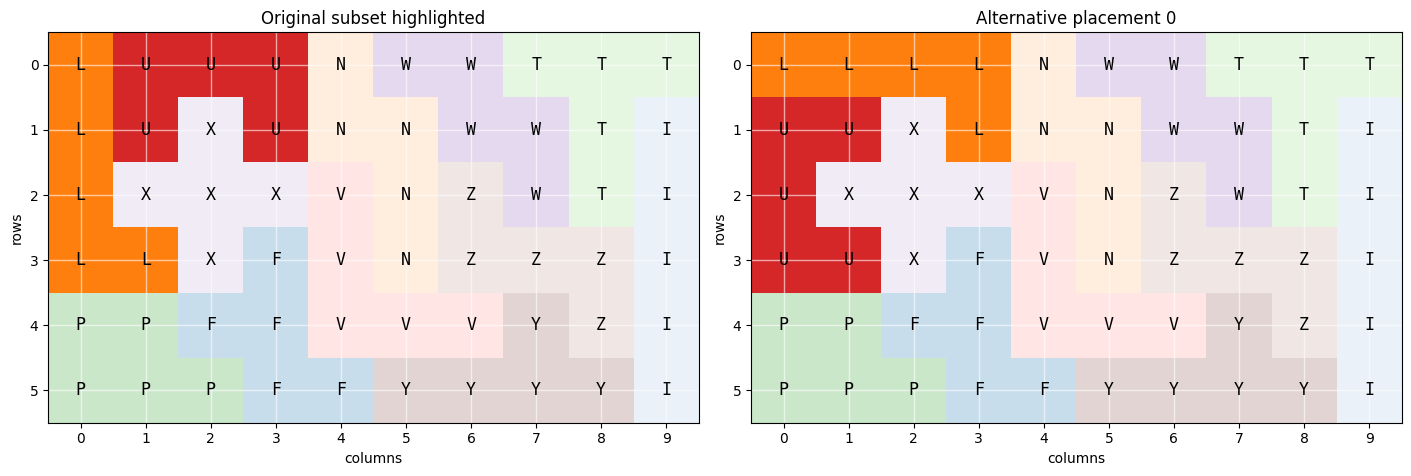

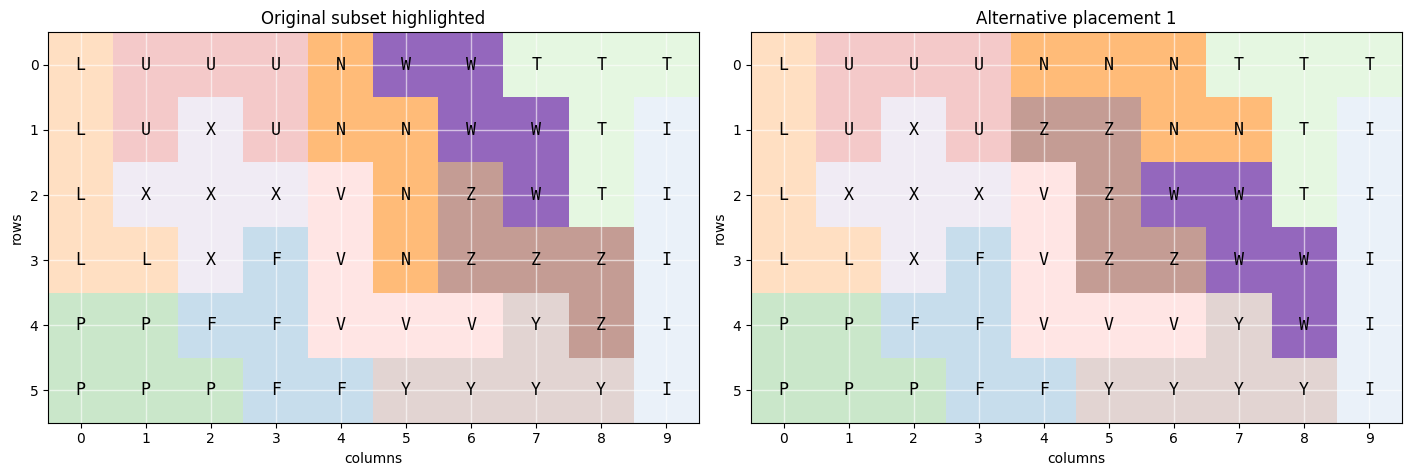

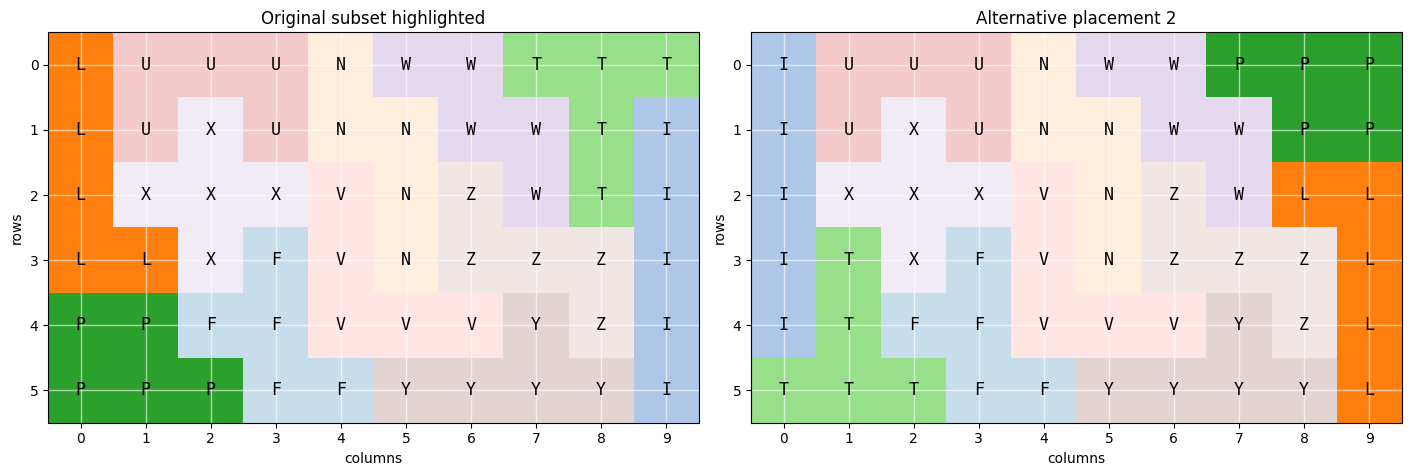

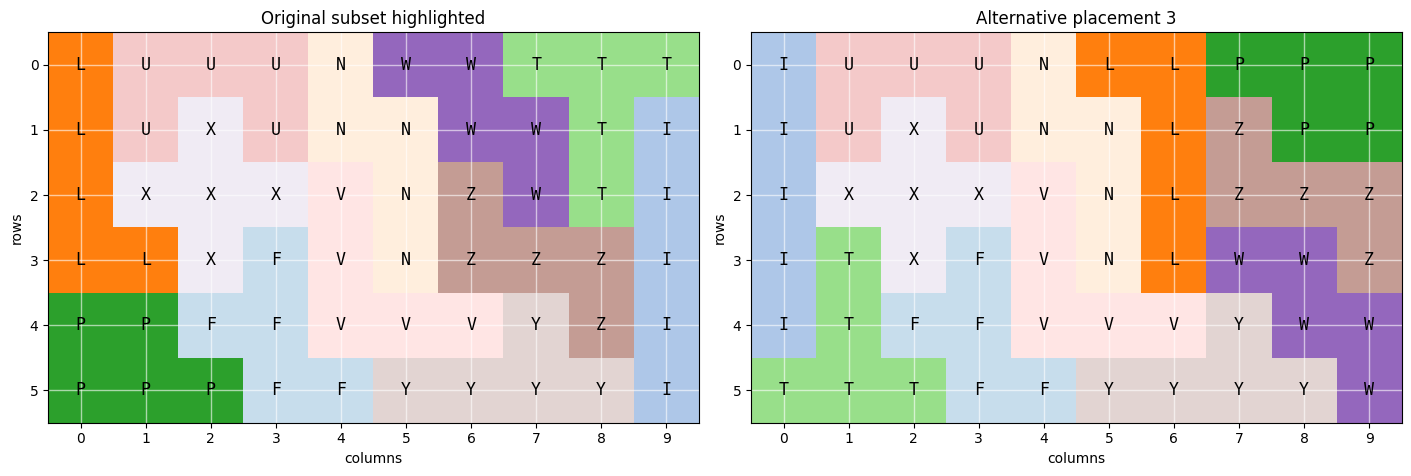

In [7]:
for i,sol in enumerate(rearrangements):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)
    plot_colored_label_grid(
        solution_grid,
        ax=axes[0],
        title="Original subset highlighted",
        highlight=sol.pieces,
    )
    plot_colored_label_grid(
        sol.alternative_grid,
        ax=axes[1],
        title=f"Alternative placement {i}",
        highlight=sol.pieces,
    )
    for ax in axes:
        ax.set_xlabel("columns")
        ax.set_ylabel("rows")

plt.show()

## Swap in your own solution

Replace `solution_grid = sample_solution()` in the setup cell with any 6×10 array of pentomino labels that matches the validation rules. Rerun the notebook cells to explore how your arrangement reacts to local rearrangement searches.
